In [1]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 4.1 MB/s eta 0:00:00


In [15]:
import os
from groq import Groq
import pandas as pd
import time

# 1. Setup
client = Groq(api_key="YOUR_GROQ_API_KEY_HERE")

# --- NEW: Define 3 Different Prompt Types (Project Req Step 2) ---
prompts_to_test = [
    {
        "Type": "Factual",
        "Text": "What is the capital of France? Answer in one word."
    },
    {
        "Type": "Creative",
        "Text": "Write a two-sentence poem about a lonely robot on Mars."
    },
    {
        "Type": "Instructional",
        "Text": "Explain how to tie a shoelace in three simple steps."
    }
]

print(f"--- Experiment Setup ---")
print(f"Testing {len(prompts_to_test)} different prompt types.")
print("-" * 50)

temperatures = [0.1, 0.7, 1.0]
results = []

# 2. The Main Loops (Prompts -> Temps -> Runs)
for p in prompts_to_test:
    p_type = p["Type"]
    p_text = p["Text"]

    print(f"\n>> Testing Category: {p_type}")
    print(f"   Prompt: \"{p_text}\"")

    for temp in temperatures:
        print(f"   |-- Temp: {temp}...", end=" ")

        for i in range(5): # Run 5 times per temp
            try:
                chat_completion = client.chat.completions.create(
                    messages=[{"role": "user", "content": p_text}],
                    model="llama-3.1-8b-instant",
                    temperature=temp,
                )
                response = chat_completion.choices[0].message.content

                # Log everything including the Prompt Category
                results.append({
                    "Prompt_Type": p_type,
                    "Prompt_Text": p_text,
                    "Temperature": temp,
                    "Run": i+1,
                    "Response": response
                })
            except Exception as e:
                print(f"Error: {e}")

            # Small delay to be nice to the API
            time.sleep(0.2)
        print("Done.")


--- Experiment Setup ---
Testing 3 different prompt types.
--------------------------------------------------

>> Testing Category: Factual
   Prompt: "What is the capital of France? Answer in one word."
   |-- Temp: 0.1... Done.
   |-- Temp: 0.7... Done.
   |-- Temp: 1.0... Done.

>> Testing Category: Creative
   Prompt: "Write a two-sentence poem about a lonely robot on Mars."
   |-- Temp: 0.1... Done.
   |-- Temp: 0.7... Done.
   |-- Temp: 1.0... Done.

>> Testing Category: Instructional
   Prompt: "Explain how to tie a shoelace in three simple steps."
   |-- Temp: 0.1... Done.
   |-- Temp: 0.7... Done.
   |-- Temp: 1.0... Done.


In [16]:
# 3. Save Data
df = pd.DataFrame(results)
df.to_csv("consistency_experiment_multiprompt.csv", index=False)
print("\n" + "="*50)
print("Experiment Complete. Saved to 'consistency_experiment_multiprompt.csv'")


Experiment Complete. Saved to 'consistency_experiment_multiprompt.csv'


In [17]:
# 4. Analysis: Compare Consistency Across Categories (Step 10)
print("\n--- Comparative Analysis: Unique Responses by Category & Temp ---")
pivot_table = df.groupby(['Prompt_Type', 'Temperature'])['Response'].nunique().unstack()
print(pivot_table)


--- Comparative Analysis: Unique Responses by Category & Temp ---
Temperature    0.1  0.7  1.0
Prompt_Type                 
Creative         1    5    5
Factual          1    1    1
Instructional    5    5    5


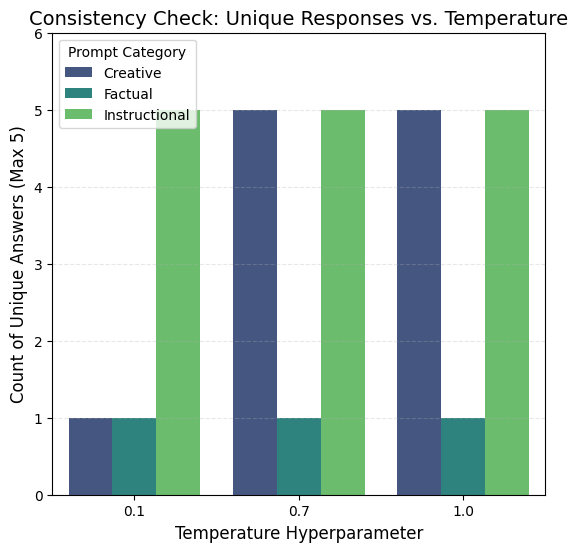

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from difflib import SequenceMatcher
import itertools

# 1. Load Data
df = pd.read_csv("consistency_experiment_multiprompt.csv")

# 2. Calculate Metrics for Visualization
# Metric A: Unique Count
unique_counts = df.groupby(['Prompt_Type', 'Temperature'])['Response'].nunique().reset_index()
unique_counts.rename(columns={'Response': 'Unique_Count'}, inplace=True)

# Metric B: Similarity Score
def calculate_similarity(responses):
    if len(responses) < 2: return 1.0
    scores = [SequenceMatcher(None, r1, r2).ratio() for r1, r2 in itertools.combinations(responses, 2)]
    return sum(scores) / len(scores)

# Group by Type & Temp to get list of responses
grouped_responses = df.groupby(['Prompt_Type', 'Temperature'])['Response'].apply(list).reset_index()
grouped_responses['Avg_Similarity'] = grouped_responses['Response'].apply(calculate_similarity)

# 3. Create Visualisations
plt.figure(figsize=(14, 6))

# --- Chart 1: Bar Chart (Unique Counts) ---
plt.subplot(1, 2, 1)
sns.barplot(data=unique_counts, x='Temperature', y='Unique_Count', hue='Prompt_Type', palette='viridis')
plt.title('Consistency Check: Unique Responses vs. Temperature', fontsize=14)
plt.ylabel('Count of Unique Answers (Max 5)', fontsize=12)
plt.xlabel('Temperature Hyperparameter', fontsize=12)
plt.ylim(0, 6)
plt.legend(title='Prompt Category')
plt.grid(axis='y', linestyle='--', alpha=0.3)



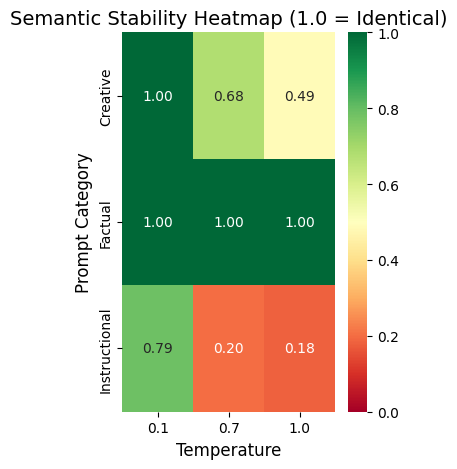

In [20]:
# --- Chart 2: Heatmap (Similarity Scores) ---
plt.subplot(1, 2, 2)
# Pivot data for heatmap format
heatmap_data = grouped_responses.pivot(index="Prompt_Type", columns="Temperature", values="Avg_Similarity")
sns.heatmap(heatmap_data, annot=True, cmap="RdYlGn", vmin=0, vmax=1, fmt=".2f")
plt.title('Semantic Stability Heatmap (1.0 = Identical)', fontsize=14)
plt.ylabel('Prompt Category', fontsize=12)
plt.xlabel('Temperature', fontsize=12)

plt.tight_layout()
plt.show()
